# Эксперименты по восстановлению профилей дисперсий для NGC338 (UGC624)

Сначала всякие настройки и импорты

In [239]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from math import *
from IPython.display import HTML
from IPython.display import Image
import os
import PIL as pil
import heapq

#Размер изображений
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 12

#Наклон галактики по данным Засова 2012
incl=64.0

# Масштаб пк/секунда из NED
scale=311.0

## 1. Наблюдательные данные

Всякие картинки и БД для большего удобства:

In [240]:
# Данные из SDSS DR9
HTML('<iframe src=http://skyserver.sdss3.org/dr9/en/tools/explore/obj.asp?ra=15.15164775&dec=30.66902519 width=1000 height=350></iframe>')

In [241]:
# Данные из HYPERLEDA
HTML('<iframe src=http://leda.univ-lyon1.fr/ledacat.cgi?o=ngc338 width=1000 height=350></iframe>')

In [242]:
# Данные из NED
HTML('<iframe src=http://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=n338&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES width=1000 height=350></iframe>')

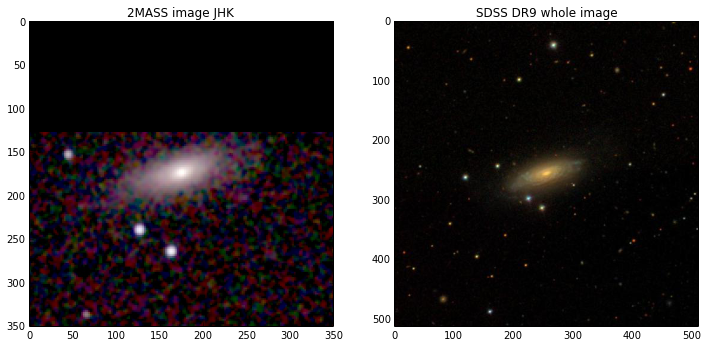

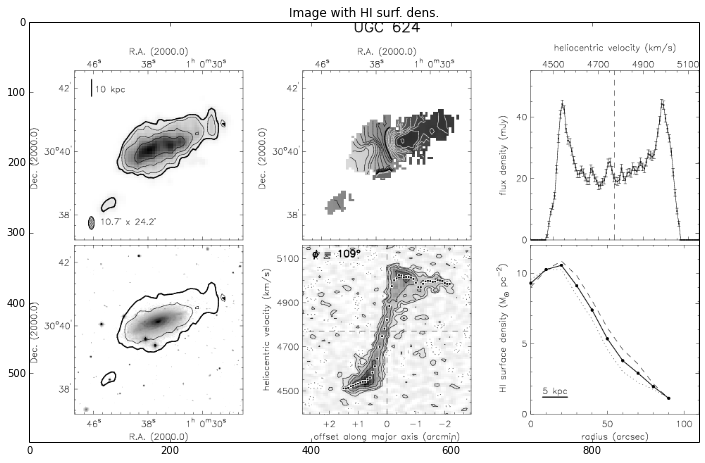

In [243]:
os.chdir("C:\\science\\2FInstability\\data\\ngc338")
try:
    from PIL import Image
except:
    import Image

fig, subplot = subplots(1, 2)
subplot[0].imshow(np.asarray(Image.open("ngc338_JHK.jpg")))
subplot[0].set_title("2MASS image JHK")
subplot[1].imshow(np.asarray(Image.open("sdss_dr9_whole.jpg")))
subplot[1].set_title("SDSS DR9 whole image")
plt.show()

plt.imshow(np.asarray(Image.open("img110.png")))
plt.title("Image with HI surf. dens.")
plt.show()

Посмотрим теперь на все доступные даные по кривым вращения. Т.к. некоторые из них скорректированы, а некоторые нет, разобьем этот этап на несколько шагов.

[]

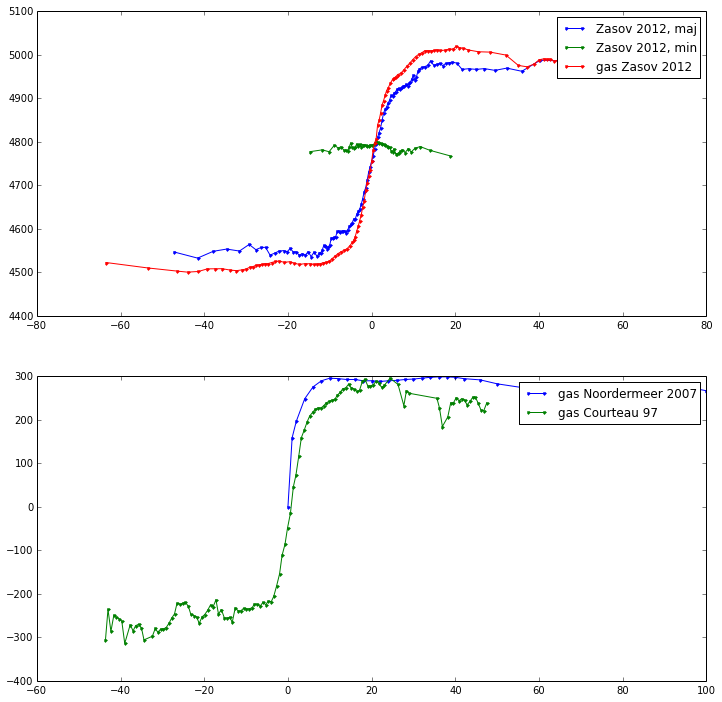

In [244]:
# Данные по звездной кинематике Засова 2012 вдоль большей полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_ma.dat", float)
r_ma, vel_ma, e_vel_ma, sig_ma, e_sig_ma = zip(*zasov_raw_data)

# Данные по звездной кинематике Засова 2012 вдоль малой полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_mi.dat", float)
r_mi, vel_mi, e_vel_mi, sig_mi, e_sig_mi = zip(*zasov_raw_data)

# Данные по кинематике газа Засова 2012 вдоль большой полуоси, не исправленные за наклон (они же Катков)
zasov_raw_data = np.loadtxt("v_gas_ma.dat", float)
r_g, vel_g, e_vel_g = zip(*zasov_raw_data)

# Данные по кинематике газа Noordermeer 2007 (исправлено за наклон)
wsrt_raw_data = np.loadtxt("v_gas_WSRT.dat", float)
r_wsrt, vel_wsrt, e_vel_wsrt = zip(*wsrt_raw_data)

# Данные по кинематике газа Courteau 97 (не исправлено за наклон)
court_raw_data = np.loadtxt("v_gas_Court.dat", float)
r_court, vel_court, e_vel_court = zip(*court_raw_data)


fig, subplot = subplots(2, 1)
subplot[0].plot(r_ma, vel_ma, '.-', label="Zasov 2012, maj")
subplot[0].plot(r_mi, vel_mi, '.-', label="Zasov 2012, min")
subplot[0].plot(r_g, vel_g, '.-', label="gas Zasov 2012")
subplot[0].legend()
subplot[1].plot(r_wsrt, vel_wsrt, '.-', label="gas Noordermeer 2007")
subplot[1].plot(r_court, vel_court, '.-', label="gas Courteau 97")
subplot[1].legend()
plt.plot()

[]

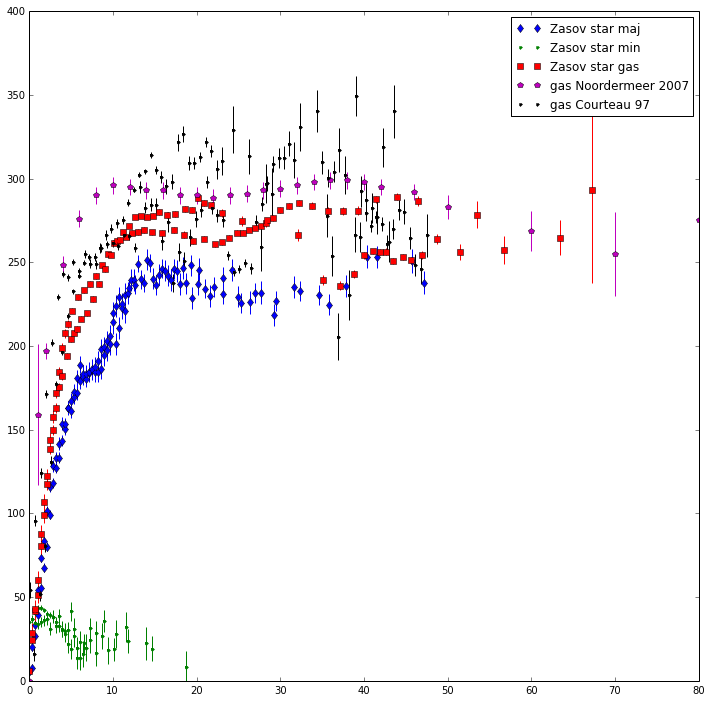

In [245]:
def incline_velocity(v, angle):
    return v / sin(angle * pi / 180)

# Переносит центр в (r0,v0) и перегибает кривую вращения, 
# а также исправляет за наклон если необходимо
def correct_rotation_curve(rdata, vdata, dvdata, r0, v0, incl):
    rdata_tmp = [abs(r-r0) for r in rdata]
    vdata_tmp = [incline_velocity(abs(v-v0), incl) for v in vdata]
    data = zip(rdata_tmp, vdata_tmp, dvdata)
    data.sort()
    return zip(*data)

r_ma_b, vel_ma_b, e_vel_b = correct_rotation_curve(r_ma, vel_ma, e_vel_ma,  0.0, 4759.845, incl)

r_mi_b, vel_mi_b, e_vel_mi_b = correct_rotation_curve(r_mi, vel_mi, e_vel_mi,  0.0, 4759.845, incl)

r_g_b, vel_g_b, e_vel_g_b = correct_rotation_curve(r_g, vel_g, e_vel_g,  0.0, 4759.845, incl)

r_c_b, vel_c_b, e_vel_c_b = correct_rotation_curve(r_court, vel_court, e_vel_court,  0.0, 0.0, incl)


plt.plot(r_ma_b, vel_ma_b, 'd', label = 'Zasov star maj')
plt.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_b, vel_mi_b, '.', label = 'Zasov star min', color='green')
plt.errorbar(r_mi_b, vel_mi_b, yerr=e_vel_mi_b, fmt='.', marker='.', mew=0, color='green')
plt.plot(r_g_b, vel_g_b, 's', label = 'Zasov star gas', color='red')
plt.errorbar(r_g_b, vel_g_b, yerr=e_vel_g_b, fmt='.', marker='.', mew=0, color='red')
plt.plot(r_wsrt, vel_wsrt, 'p', label="gas Noordermeer 2007", color='m')
plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='m')
plt.plot(r_c_b, vel_c_b, '.', label = 'gas Courteau 97', color='black')
plt.errorbar(r_c_b, vel_c_b, yerr=e_vel_c_b, fmt='.', marker='.', mew=0, color='black')
plt.xlim(0, 80.0)
plt.ylim(0)
plt.legend()
plt.plot()

В дальнейшем используем только засовские данные по звездам по большой полуоси и газу. Приблизим первую из них полиномом. 

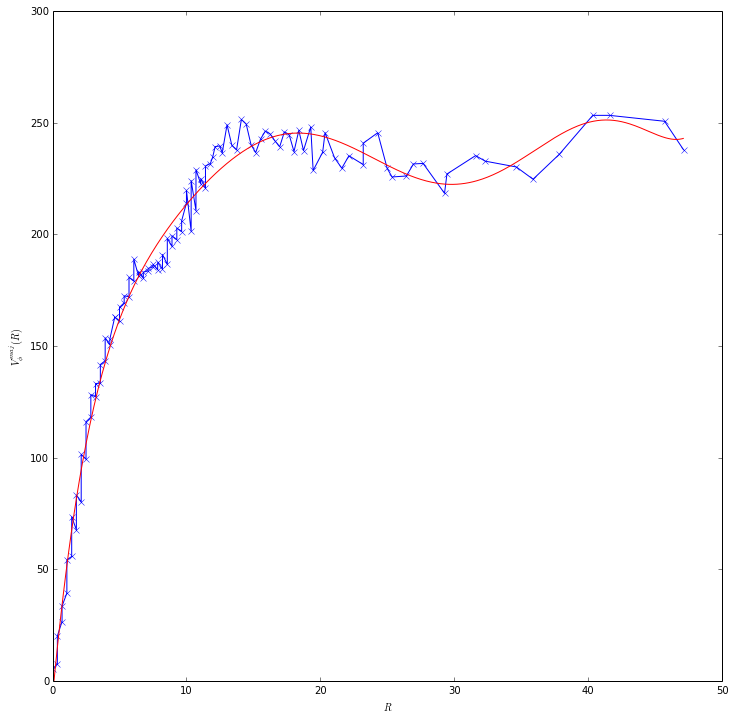

In [246]:
poly_star = poly1d(polyfit(r_ma_b, vel_ma_b, deg=7))

plt.plot(r_ma_b, vel_ma_b, 'x-', color='blue', markersize=6)
test_points = np.arange(0.0, max(r_ma_b), 0.1)
plt.plot(test_points, poly_star(test_points), '-', color='red')
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V^{maj}_{\phi}(R)$')
plt.show()

Кривая вращения нам нужна для нахождения соотношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, которое описывается уравнением ${\displaystyle \sigma_{\varphi}^{2}/\sigma_{R}^{2}=0.5\left(1+\frac{R}{\bar{v}_{\varphi}}\frac{d\bar{v}_{\varphi}}{dR}\right)}$ (Binney & Tremaine, 1987) и приближается гладко функцией $f=0.5(1+e^{-R/R_{0}}),$ где $R_{0}$ --- характерный масштаб. 

${\bf Примечание:}$ Такое приближение оправдано следующими соображениями. Для равновесного диска верно уравнение, описанное выше. Для твердотельного участка вращения в центральных областях выражение в скобках равно 2, а $\sigma_{\varphi}^{2}/\sigma_{R}^{2}=1$. На плоском участке кривой вращения на периферии диска $\sigma_{\varphi}^{2}/\sigma_{R}^{2}\thickapprox0.5$. Функция $f$ как раз аппроксимирует такое поведение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$.

Изобразим получившийся профиль $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, вычисляемый через производную полинома:

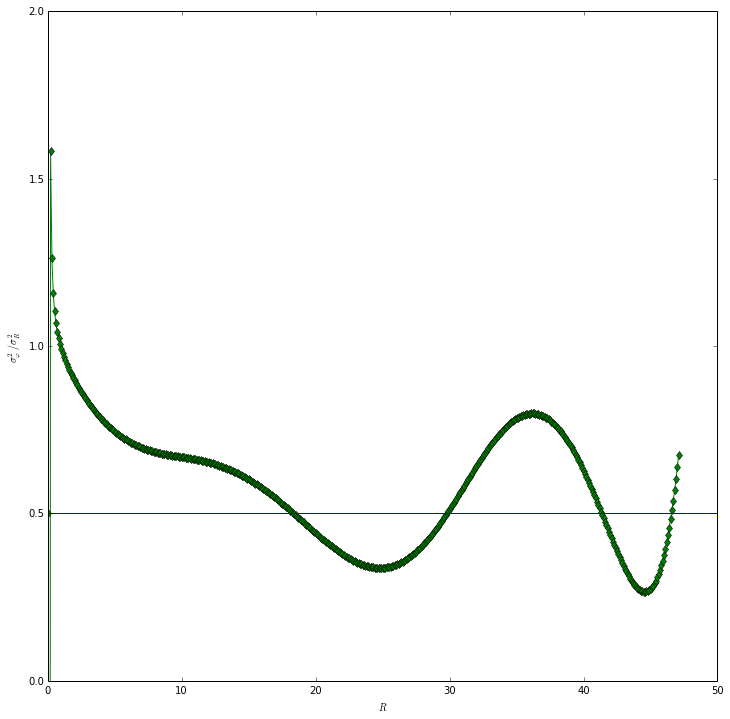

In [247]:
def sigPhi_to_sigR_real(R):
        return 0.5 * (1 + R*poly_star.deriv()(R) / poly_star(R))

plt.plot(test_points, [sigPhi_to_sigR_real(R) for R in test_points], 'd-', color='green')
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.xlabel('$R$')
plt.ylabel(r"$\sigma_{\varphi}^2/\sigma_{R}^2$")
plt.ylim(0)
plt.show()

Найдем теперь характерный масштаб $f=0.5(1+e^{-R/R_{0}})$:

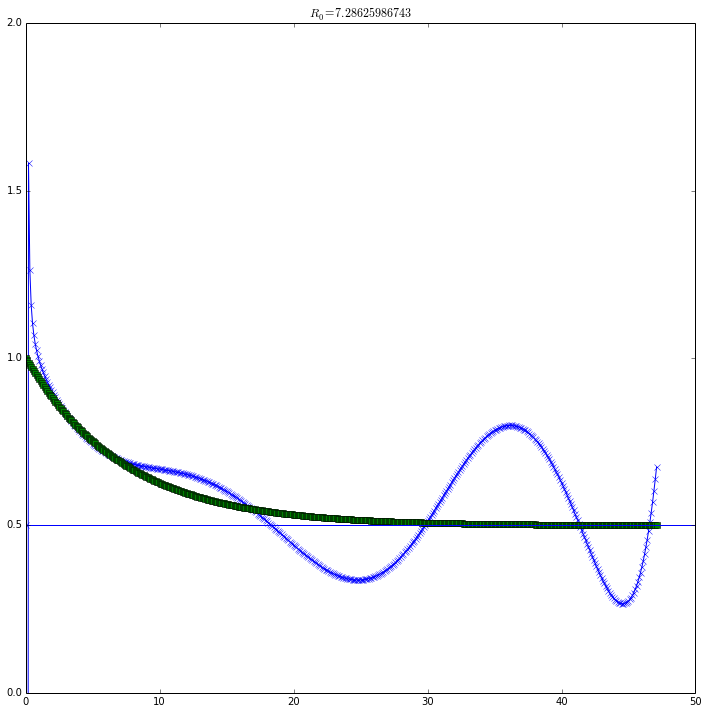

In [248]:
def f(R, Ro):
    return 0.5*(1 + np.exp( -R/Ro ))

xdata = test_points
ydata = sigPhi_to_sigR_real(xdata)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, xdata, ydata, p0=[1.0])
Ro = popt[0]

plt.plot(xdata, ydata, 'x-')
plt.plot(xdata, [f(p, Ro) for p in xdata], 's')
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.title('$R_{0} = %s $' % Ro)
plt.ylim(0)
plt.show()

Теперь знаем значение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$ в любой точке, заведем соответствующую функцию:

In [249]:
def sigPhi_to_sigR(R):
    return sqrt(f(R, Ro))

Построим графики дисперсий скоростей на луче зрения вдоль большой и малой оси ($\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$):

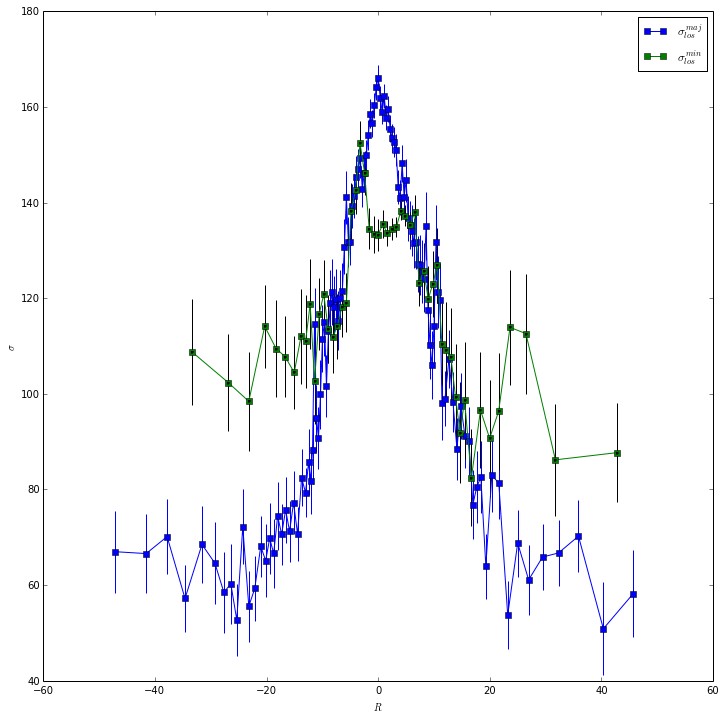

In [250]:
# Исправляем значения вдоль малой оси на синус угла:    
def correct_min(R):    
    return R / cos(incl * pi / 180) 

r_mi_extend = map(correct_min, r_mi)
    
plt.plot(r_ma, sig_ma, 's-', label='$\sigma_{los}^{maj}$')
plt.errorbar(r_ma, sig_ma, yerr=e_sig_ma, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_extend, sig_mi, 's-', label='$\sigma_{los}^{min}$')
plt.errorbar(r_mi_extend, sig_mi, yerr=e_sig_mi, fmt='.', marker='.', mew=0, color='black')
plt.xlabel('$R$')
plt.ylabel('$\sigma$')
plt.legend()
plt.show()

Перегнем и приблизим полиномами:

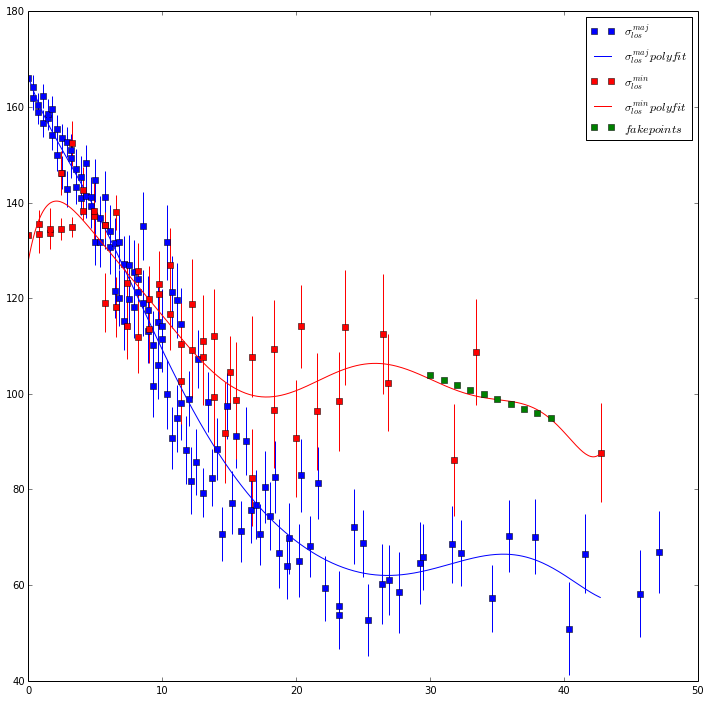

In [251]:
bind_curve = lambda p: (abs(p[0]), abs(p[1]), p[2])
sig_maj_data = zip(r_ma, sig_ma, e_sig_ma)
sig_maj_data = map(bind_curve, sig_maj_data)
sig_maj_data.sort()
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 

poly_sig_maj = poly1d(polyfit(radii_maj, sig_maj_p, deg=9))

sig_min_data = zip(r_mi_extend, sig_mi, e_sig_mi)
sig_min_data = map(bind_curve, sig_min_data)
sig_min_data.sort()
radii_min, sig_min_p, e_sig_min_p = zip(*sig_min_data) 

# Добавляем лишние точки чтобы протянуть дальше
num_fake_points = 10; expscale = 100.0
fake_radii, fake_sig = zip(*[(29.0 + i, 105*exp(- i / expscale )) for i in range(1, num_fake_points+1)])

poly_sig_min = poly1d(polyfit(radii_min + fake_radii, sig_min_p + fake_sig, deg=9))

points = np.arange(0, max(radii_min), 0.1)
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(fake_radii, fake_sig, 'bs', color='green', label='$fake points$')
plt.legend()
# plt.ylim(40, 200)
plt.show()

Посчитаем величину невязок для полученного приближения:

In [252]:
sqerr_maj = sum(power([poly_sig_maj(p[0]) - p[1] for p in sig_maj_data], 2))
sqerr_min = sum(power([poly_sig_min(p[0]) - p[1] for p in sig_min_data], 2))

chi2_maj = sqerr_maj / len(sig_maj_p)
chi2_min = sqerr_min / len(sig_min_p)

print "Poly chi^2 for maj full = %s, mean = %s" % (sqerr_maj, chi2_maj)
print "Poly chi^2 for min full = %s, mean = %s" % (sqerr_min, chi2_min)

Poly chi^2 for maj full = 6018.46868188, mean = 53.2607847954
Poly chi^2 for min full = 2975.50305433, mean = 57.2212125833


## 2. Аналитическое восстановление профиля 

### 2.1 Из МНК

Методика восстановления профилей $\sigma_{R}(R)$, $\sigma_{\varphi}(R)$ и $\sigma_{z}(R)$ следующая. Представим, что $\sigma_{Z}/\sigma_{R} \equiv \alpha \equiv const$. Тогда, зная значения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}=f(R)$ в каждой точке, получаем из уравнений, описанных выше: $$\sigma_{los,maj}^2=\sigma_R^2[f\sin^2i+\alpha^2\cos^2i]$$ $$\sigma_{los,min}^2=\sigma_R^2[\sin^2i+\alpha^2\cos^2i]$$
Представим теперь $\sigma_R(R)=\sigma_{R,0}\times F(R)$, где $F(0)=1$. Значение в квадратных скобках для $\sigma_{los,min}$ равно константе и, следуя предположению, получаем представление для дисперсии вдоль луча зрения для малой оси как $\sigma_{los,min}(R)=\sigma_{min,0}\times F(R)$. Очевидно $\sigma_{min,0} = \sigma_{los,min}(0)$, а значит мы знаем в каждой точке значение $F(R)=\sigma_{los,min(R)}/\sigma_{min,0}$. Описанная выше система уравнений вырождается в следующую:
$$\sigma_{los,maj}^2(R)=\frac{\sigma_{R,0}^2\sigma_{los,min}^2(R)[f\sin^2i+\alpha^2\cos^2i]}{\sigma_{min,0}^2}$$ $$\sigma_{min,0}^2=\sigma_{R,0}^2\sin^2i+\sigma_{R,0}^2\alpha^2\cos^2i$$
Сделаем замену: $\sigma_{R,0}^2\sin^2 i \equiv A,\ \sigma_{R,0}^2\cos^2 i\times \alpha^2 \equiv B$. Окончательно, имеем $N+1$ линейное уравнение для $N$ точек, которые можем решить МНК: 
$$\left\{
  \begin{array}{lr}
    \sigma_{los,maj}^2(R_j)\times \sigma_{min,0}^2 =\sigma_{los,min}^2(R_j)[Af(R_j)+B]\\
    \sigma_{min,0}^2=A+B
  \end{array}
\right.
$$

In [253]:
#Обрезаем данные по x > r_eff
r_eff = 20.0

#Значение sig_los_min в 0
sig_min_0 = poly_sig_min(0)

#Правая граница
r_max = 41.0

#Количество точек N и сами точки
N = 6
radii_points = np.arange(r_eff, r_max, (r_max-r_eff)/N)

#Как вычислять ошибку 
def residuals(params, xdata, ydata):
            return (ydata - numpy.dot(xdata, params))

#Начальное приближение (А,В)
x0 = [1000, 1000]

#Уравнения:  одно для min и N для maj
#Левая часть:
eq_left = np.concatenate( ([sig_min_0**2], 
                              [poly_sig_maj(p)**2 * sig_min_0**2  for p in radii_points]) )
#Правая часть:
eq_right = np.transpose(
            np.array([
                np.concatenate(([1.0],
                                   [poly_sig_min(R)**2 * sigPhi_to_sigR(R)**2 for R in radii_points])),
                np.concatenate(([1.0],
                                   [poly_sig_min(R)**2 for R in radii_points]))]))

# Что будет, если выкинуть уравнение для min:
# eq_left = np.array([poly_sig_maj(p)**2 * sig_min_0**2  for p in radii_points])
# eq_right = np.transpose(
#             np.array([[poly_sig_min(R)**2 * sigPhi_to_sigR(R)**2 for R in radii_points],
#                                    [poly_sig_min(R)**2 for R in radii_points]]))

# МНК для получившихся уравнений:
solution = scipy.optimize.leastsq(residuals, x0, args=(eq_right, eq_left))[0]
A, B = solution[0], solution[1]

chi2 = sum(power(residuals(solution, eq_right, eq_left), 2))
        
print 'Solution: A = %s, B = %s' % (A, B)
print 'Chi^2:', chi2

#Подставить в уравнение в какой-нибудь точке:
# rrr = 25.0
# print (poly_sig_maj(rrr)**2) * sig_min_0**2 - (poly_sig_min(rrr)**2) * (A*f(rrr, Ro)+B)

Solution: A = 10896.9503304, B = 1047.44918527
Chi^2: 4.06733269423e+14


Теперь восстановим исходные неизвестные - $\alpha$ и $\sigma_{R, 0}$: 

In [254]:
sig_R_0 = round( sqrt(A) / sin(incl*pi/180), 3)
alpha = round( sqrt(B)/ (cos(incl*pi/180) * sig_R_0), 3)

# sig_R_0 = 160
# alpha = 0.55

print "sig_R_0 = %s, alpha = %s" % (sig_R_0, alpha)

sig_R_0 = 116.143, alpha = 0.636


Построим полученные профили дисперсий скоростей:

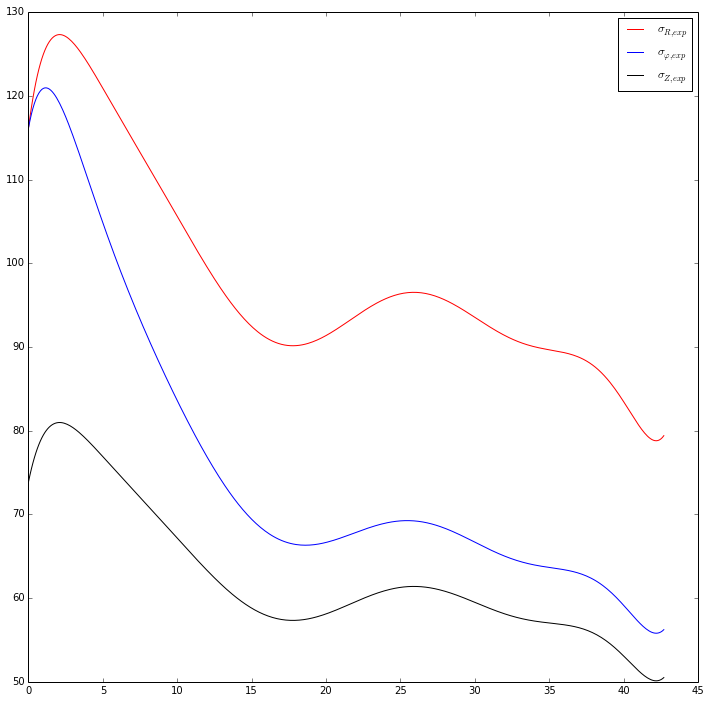

In [255]:
def sigR_exp(R):
    return sig_R_0*poly_sig_min(R)/sig_min_0

def sigZ_exp(R):
    return alpha * sigR_exp(R)

def sigPhi_exp(R):
    return sigPhi_to_sigR(R) * sigR_exp(R)


plt.plot(points, [sigR_exp(R) for R in points], '-', color='red', label='$\sigma_{R, exp}$')
plt.plot(points, [sigPhi_exp(R) for R in points], '-', color='blue', label=r'$\sigma_{\varphi, exp}$')
plt.plot(points, [sigZ_exp(R) for R in points], '-', color='black', label='$\sigma_{Z, exp}$')
plt.legend()
plt.show()

И восстановим профили $\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$. Связь профилей описывается следующими уравнениями: $$\sigma_{los,maj}^2=\sigma_{\varphi}^2\sin^2i+\sigma_Z^2\cos^2i$$ $$\sigma_{los,min}^2=\sigma_R^2\sin^2i+\sigma_Z^2\cos^2i$$

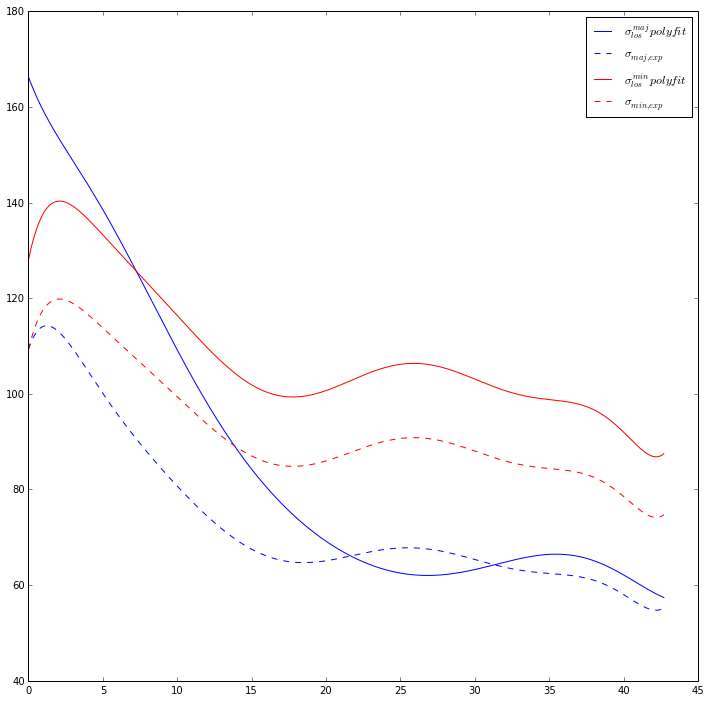

In [256]:
def sig_maj_exp(R):
    return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

def sig_min_exp(R):
    return sqrt(sigR_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

plt.plot(points, poly_sig_maj(points), '-', label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue', label='$\sigma_{maj, exp}$')
plt.plot(points, poly_sig_min(points), '-', label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(points, [sig_min_exp(R) for R in points], '--', color='red', label='$\sigma_{min, exp}$')
plt.legend()
plt.show()

Попробуем поискать точки, в которых МНК решается лучше всего:

In [257]:
#Восстановление первоначальных неизвестных
def physical_unknowns(A, B):
    sig_R_0 = round( sqrt(A) / sin(incl*pi/180), 3)
    alpha = round( sqrt(B)/ (cos(incl*pi/180) * sig_R_0), 3)
    return (sig_R_0, alpha)

#Значение sig_los_min в 0
sig_min_0 = poly_sig_min(0.)

Ns = [50, 75, 100]

right_max = 42.

#Шаг сетки по расстоянию
dx = 2.

#Минимальный размер отрезка, на котором ищем ответ
min_size = 10.

lefts = np.arange(0, right_max, dx)

best = []

for n in Ns:
    result_for_N = []
    for left in lefts:
        rights = np.arange(left+min_size, right_max, dx)
        for right in rights:
            r_points = np.arange(left, right, (right-left)/n)
            eq_left = np.concatenate( ([sig_min_0**2], 
                              [poly_sig_maj(p)**2 * sig_min_0**2  for p in r_points]) )
            eq_right = np.transpose(
                        np.array([
                            np.concatenate(([1.0],
                                               [poly_sig_min(R)**2 * sigPhi_to_sigR(R)**2 for R in r_points])),
                            np.concatenate(([1.0],
                                               [poly_sig_min(R)**2 for R in r_points]))]))
            solution = scipy.optimize.leastsq(residuals, x0, args=(eq_right, eq_left))[0]
            A, B = solution[0], solution[1]
            chi2 = sum(power(residuals(solution, eq_right, eq_left), 2))/n
            if A > 0 and B > 0:
                result_for_N.append([chi2, left, right-left, A, B])
    if result_for_N.__len__() > 0:
        result_for_N.sort()
        Z,X,Y,A,B = zip(*result_for_N)
        print "For N=%s top-10 best results:" % n
        for ind in range(0, min(10, Z.__len__())):
            prin = (ind+1, Z[ind], X[ind], X[ind]+Y[ind]) + physical_unknowns(A[ind], B[ind])
            print "\t%s place: chi2 = %s in range [%s:%s]; sig_R_0 = %s alpha = %s" % prin
        if best.__len__() == 0 or best[0] > Z[0]:
            best = [Z[0], X[0], Y[0], n]

if best.__len__() > 0:
    print "Best of the best: N=%s chi2 = %s on range[%s:%s]" % (best[3], best[0], best[1], best[2]+best[1])

For N=50 top-10 best results:
	1 place: chi2 = 4.04863391071e+13 in range [2.0:12.0]; sig_R_0 = 159.204 alpha = 0.633
	2 place: chi2 = 4.98361630777e+13 in range [20.0:36.0]; sig_R_0 = 14.397 alpha = 12.567
	3 place: chi2 = 6.46197044044e+13 in range [2.0:14.0]; sig_R_0 = 167.1 alpha = 0.246
For N=75 top-10 best results:
	1 place: chi2 = 4.08940111744e+13 in range [2.0:12.0]; sig_R_0 = 159.483 alpha = 0.623
	2 place: chi2 = 6.50160270705e+13 in range [2.0:14.0]; sig_R_0 = 167.464 alpha = 0.218
For N=100 top-10 best results:
	1 place: chi2 = 4.10909449989e+13 in range [2.0:12.0]; sig_R_0 = 159.626 alpha = 0.618
	2 place: chi2 = 6.52004825621e+13 in range [2.0:14.0]; sig_R_0 = 167.649 alpha = 0.202
Best of the best: N=50 chi2 = 4.04863391071e+13 on range[2.0:12.0]


### 2.2 Аналитически

Заметим, что можно было не решать систему МНК, а честно разрешить систему из двух уравнений $$\left\{
  \begin{array}{lr}
    \sigma_{los,maj}^2(R_j)\times \sigma_{min,0}^2 =\sigma_{los,min}^2(R_j)[Af(R_j)+B]\\
    \sigma_{min,0}^2=A+B
  \end{array}
\right.
$$ относительно $A$ и $B$ для почти любого $R_j$ (а лучше даже относительно начальных неизвестных - $\sigma_{R,0}$ и $\alpha$).
Решение: $$\sigma_{R,0}^2 = \frac{\sigma_{min,0}^2}{\sin^2 i}\times\frac{1}{f(R)-1}\times(P(R)-1)$$ $$\alpha^2 = \tan^2 i\frac{f(R) - P(R)}{P(R)-1},$$ $$P(R)=\frac{\sigma_{los,maj}^2(R)}{\sigma_{los, min}^2(R)}$$ Имеет смысл также искать не $\alpha$, а $\alpha\cdot\sigma_{R,0}=\sigma_{Z,0}$.

In [258]:
cos_i, sin_i = cos(incl * pi / 180), sin(incl * pi / 180)

def P(R):
    """Отношение maj к min, как описано выше"""
    return (poly_sig_maj(R)/poly_sig_min(R))**2

def direct_solve_A(R):
    """Аналитически находим значение sig_R_0 для уравнения в точке R"""
    res = sig_min_0**2 * (P(R) - 1) / (sin_i**2 * (sigPhi_to_sigR(R)**2 - 1))
    return sqrt(res) if res > 0 else 0

def direct_solve_B(R):
    """Аналитически находим значение alpha для уравнения в точке R"""
    res = (sigPhi_to_sigR(R)**2 - P(R))/(P(R) - 1) * (sin_i/cos_i)**2
    return sqrt(res) if res > 0 else 0

def direct_find_sig_R_0(R):
    return direct_solve_A(R)

def direct_find_sig_Z_0(R):
    return direct_solve_A(R) * direct_solve_B(R)

Найдем значения $\sigma_{R,0}$ и $\sigma_{Z,0}$ для всех точек на большой оси:

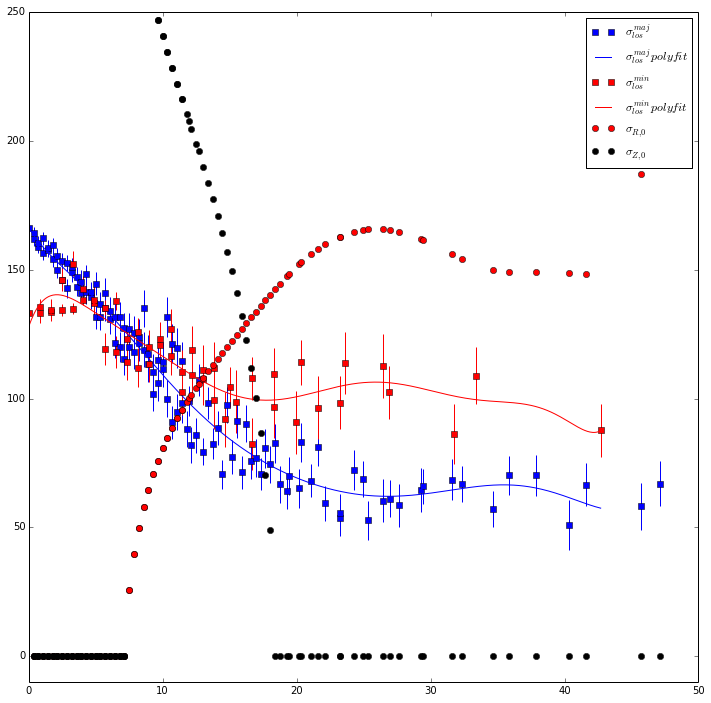

In [259]:
p_r = radii_maj

direct_sigR0 = map(direct_find_sig_R_0, p_r)
direct_sigZ0 = map(direct_find_sig_Z_0, p_r)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')

plt.plot(p_r, direct_sigR0, 'o', color='r', label='$\sigma_{R,0}$')
plt.plot(p_r, direct_sigZ0, 'o', color='k', label='$\sigma_{Z,0}$')

plt.legend()
plt.ylim(-10, 250)
plt.show()

Как видно - хорошо восстанавливаются значения $\sigma_{R,0}$ - лежат относительно одной прямой, найдем их среднее:

In [260]:
#Обрежем по 13
q=13.
ind_q = p_r.index(filter(lambda l: l > q, p_r)[0])

poly_q = poly1d(polyfit(p_r[ind_q:], direct_sigR0[ind_q:], deg=0))
print "sig_R poly mean = %s" % poly_q[0]

sig_R poly mean = 146.749801291


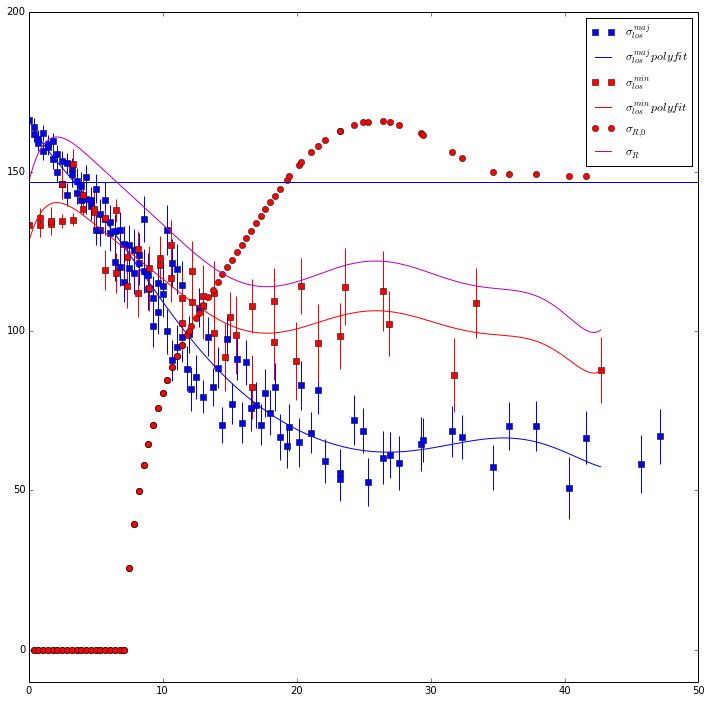

In [261]:
sig_R_0 = poly_q[0]

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')

plt.plot(p_r, direct_sigR0, 'o', color='r', label='$\sigma_{R,0}$')
plt.axhline(y=sig_R_0)

#Строим полученный на основе среднего профиль sig_R
plt.plot(points, poly_sig_min(points)*sig_R_0/sig_min_0, label = '$\sigma_R$', color='m')

plt.legend()
plt.ylim(-10, 200)
plt.show()

### 2.3 Из верхней оценки

Как мы видим, значения профиля дисперсии $\sigma_R(R)$ восстанавливаются довольно надежно, однако оказываются по-видимому больше реальных и поэтому не получается восстановить профиль в вертикальном направлении. Попробуем оценить, насколько этот вклад оказывается переоценен в данном случае. Известно, что отношение $\sigma_Z/\sigma_R$ не может быть меньше некоего порогового значения, в противном случае галактика будет неустойчива к осесимметричным изгибным возмущениям плотности. Многие авторы оценивали эту величину, в том числе Засов, однако последния статья Сотниковой и Радионова "Bending instability in galactic discs. Advocacy of the linear theory" (2013, http://arxiv.org/abs/1306.5975) продемонстрировала, что искомое попроговое значение близко к таковому, полученному из линейной теории Тумре в 1966 год и равно примерно 0.3. Чем это ценно для нас? Если мы примем, что $\frac{\sigma_Z}{\sigma_R} \gtrsim 0.3,$ то, исходя из уравнения $\sigma_{los,min}^2=\sigma_R^2\sin^2i+\sigma_Z^2\cos^2i$ можем получить оценку сверху на значения радиальной дисперсии: $$\frac{\sigma_{los,min}}{\sqrt{\sin^2i+0.09\cos^2i}} \gtrsim \sigma_R$$ Также аналогичную оценку, только чуть более сложную, можно сделать и для данных вдоль большой оси.

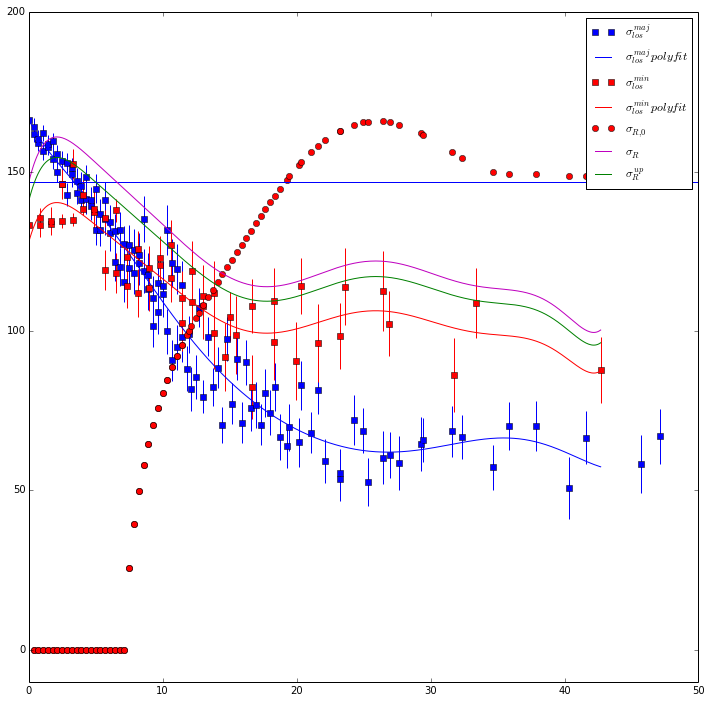

In [262]:
def sig_R_upper_lim(R, alpha):
    """Оценка сверху на sigR(R)"""
    return poly_sig_min(R)/sqrt(sin_i**2 + alpha**2 * cos_i**2)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')

plt.plot(p_r, direct_sigR0, 'o', color='r', label='$\sigma_{R,0}$')
plt.axhline(y=sig_R_0)
plt.plot(points, poly_sig_min(points)*sig_R_0/sig_min_0, label = '$\sigma_R$', color='m')
plt.plot(points, [sig_R_upper_lim(R, 0.3) for R in points], label = '$\sigma_R^{up}$', color='g')

plt.legend()
plt.ylim(-10, 200)
plt.show()

Как видим, значения действительно оказались переоценены минимум на 5 км/c. Посмотрим, насколько сильно верхняя оценка зависит от $\alpha$:

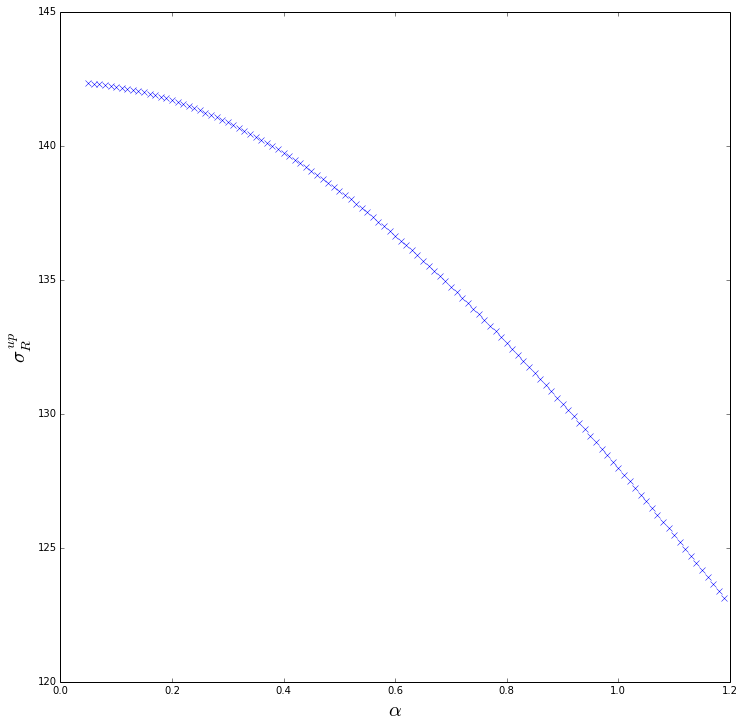

In [263]:
alphas = np.arange(0.05, 1.2, 0.01)

plt.plot(alphas, [sig_R_upper_lim(0., a) for a in alphas], 'x')
plt.xlabel(r'$\alpha$', size = 20.)
plt.ylabel('$\sigma_R^{up}$', size=20.)
plt.show()

Как видим, разброс существенный. Давайте ради интереса попробуем восстановить эллипсоид скоростей и исходные профили, исходя из условия об маржинальной устойчивости диска относительно изгибных возмущений: 

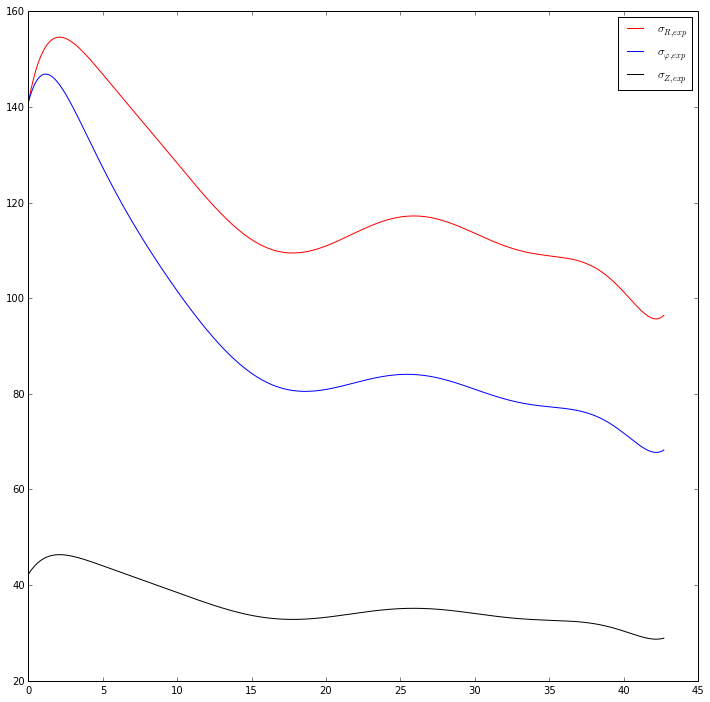

In [264]:
sig_R_0 = 141.
alpha = 0.3

plt.plot(points, [sigR_exp(R) for R in points], '-', color='red', label='$\sigma_{R, exp}$')
plt.plot(points, [sigPhi_exp(R) for R in points], '-', color='blue', label=r'$\sigma_{\varphi, exp}$')
plt.plot(points, [sigZ_exp(R) for R in points], '-', color='black', label='$\sigma_{Z, exp}$')
plt.legend()
plt.show()

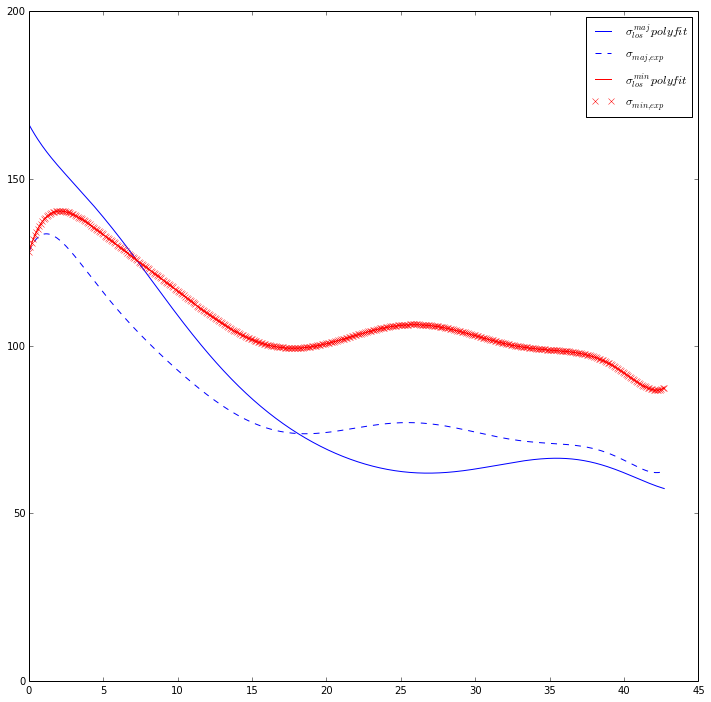

In [265]:
plt.plot(points, poly_sig_maj(points), '-', label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(points, [sig_maj_exp(Rr) for Rr in points], '--', color='blue', label='$\sigma_{maj, exp}$')
plt.plot(points, poly_sig_min(points), '-', label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(points, [sig_min_exp(R) for R in points], 'x', color='red', label='$\sigma_{min, exp}$')
plt.legend()
plt.ylim(0, 200)
plt.show()

Согласие довольно неплохое!

### 2.4 Перебор значений

Теперь то, с чего надо было начинать - построим картинки для разных значений $\alpha$ и $\sigma_{R,0}$. Для того, чтобы найти где минимум, попробуем построить просто двумерные карты $\chi^2$ для разных $\sigma_{R,0}$  $\alpha$: (это очень долго, так что пересчитывать в крайнем случае, а так - храним посчитанные данные в файлах) 

In [266]:
alphas = np.arange(0.25, 1., 0.005)
sigmas = np.arange(100.0, 200, 0.25)

def compute_chi2_maps(alphas=(), sigmas=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigmas), len(alphas)))
    image_maj = np.random.uniform(size=(len(sigmas), len(alphas)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigmas):
        for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            sqerr_sum = 0.5*sqerr_maj+0.5*sqerr_min
            image[i][j] = sqerr_sum
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image, image_maj, image_min

pics_path = '.\\pics\\'
if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'chi2_map.npy'):
    image = np.load(pics_path + "chi2_map.npy")
    image_maj = np.load(pics_path + "chi2_map_maj.npy")
    image_min = np.load(pics_path + "chi2_map_min.npy")
else:
    image, image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)
    np.save(pics_path + 'chi2_map', image)
    np.save(pics_path + 'chi2_map_maj', image_maj)
    np.save(pics_path + 'chi2_map_min', image_min)

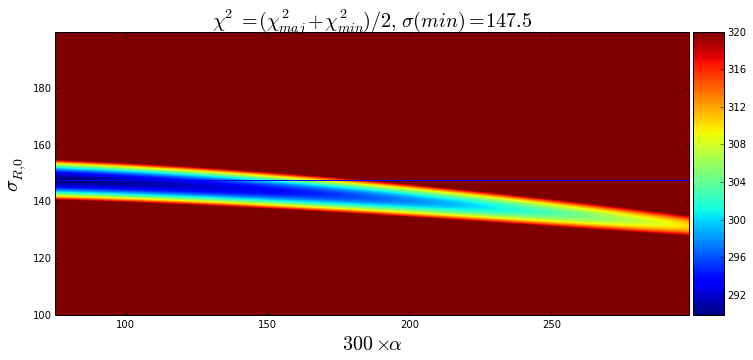

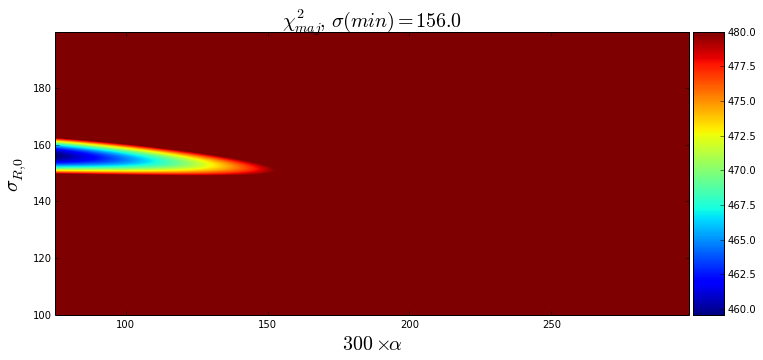

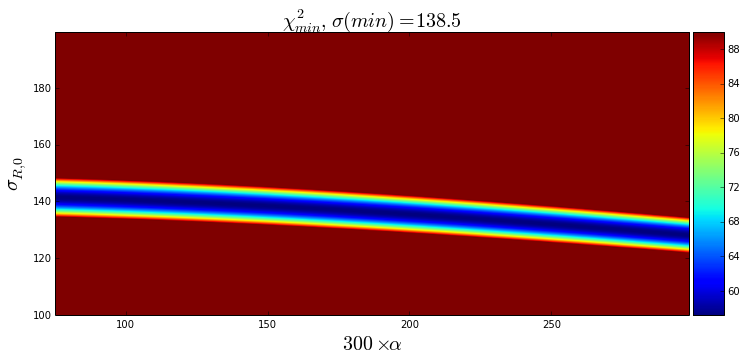

In [267]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_chi2_map(image=None, image_maj=None, image_min=None):
    '''Рисуем получившиеся карты.
    Colormaps: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps'''
    
    if image is not None:
        ax = plt.gca()
        im = ax.imshow(image, cmap='jet', vmin=image.min(), vmax=320., interpolation='spline16', 
                   origin="lower", extent=[300*alphas[0], 300*alphas[-1],sigmas[0],sigmas[-1]] )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(numpy.where(image == image.min())[0])]
        ax.set_title('$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2,\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$300\times \alpha$', size=20.)
        ax.axhline(y=min_sigma)
        plt.show()

        
    if image_maj is not None:
        ax = plt.gca()
        im = ax.imshow(image_maj, cmap='jet', vmin=image_maj.min(), vmax=480., interpolation='spline16', 
                   origin="lower", extent=[300*alphas[0], 300*alphas[-1],sigmas[0],sigmas[-1]] )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(numpy.where(image_maj == image_maj.min())[0])]
        ax.set_title('$\chi^2_{maj},\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$300\times \alpha$', size=20.)
        plt.show()
        
    if image_min is not None:
        ax = plt.gca()
        im = ax.imshow(image_min, cmap='jet', vmin=image_min.min(), vmax=90., interpolation='spline16', 
                   origin="lower", extent=[300*alphas[0], 300*alphas[-1],sigmas[0],sigmas[-1]] )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(numpy.where(image_min == image_min.min())[0])]
        ax.set_title('$\chi^2_{min},\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$300\times \alpha$', size=20.)
        plt.show()
    
    
plot_chi2_map(image=image, image_maj=image_maj, image_min=image_min)

Как видно, вне заисимости от $\alpha$ значения $\sigma_{R,0}$ оказываются равными 150$\pm$15. Научимся также изображать сами восстановленные профили при разбросе параметров: 

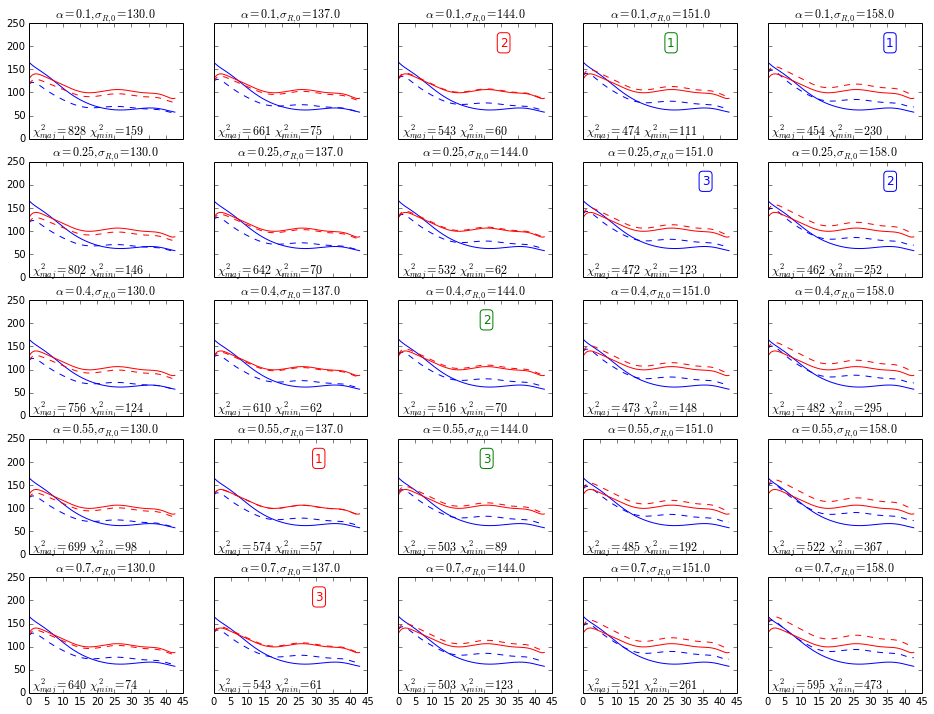

In [268]:
# Перебор alpha
alphas = np.arange(0.1, 0.85, 0.15)

# Перебор sig_R_0
sigmas = np.arange(130., 165., 7.)

# Те картинки, на которые стоит обратить особое внимание
good_pics = []

def plot_ranges(sigmas_range, alphas_range, good_pics=[], calc_chi=False, best_err=3):
    '''
    Для всех предложенных вариантов sigR и alpha
    рисует графики исходных и восстановленных дисперсий скоростей los.
    Если calc_chi = True, то также считает ошибку по наблюдаемым точкам.
    Если ошибка считается, то отмечаются best_err лучших (наименьших) результата.
    Синий - для большой оси, красный - малой, зеленый - полусумма.
    Изменяет глобальные значения sig_R_0 и alpha!'''
    nrows = alphas.size
    ncols = sigmas.size
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=[16,12])
    plt_index = 0
    # Последнее - среднее геометрическое
    sqerr_majs, sqerr_mins, sqerr_mean = [],[],[]
    for al in alphas_range:
        for si in sigmas_range:
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            ax = axes[plt_index/ncols, plt_index % ncols]
            ax.set_title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (al,si))
            ax.plot(points, poly_sig_maj(points), '-', color='blue')
            ax.plot(points, [sig_maj_exp(Rr) for Rr in points], '--', color='blue')
            ax.plot(points, poly_sig_min(points), '-', color='red')
            ax.plot(points, [sig_min_exp(R) for R in points], '--', color='red')
            if calc_chi:
                sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
                sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
                ax.text(1, 5, "$\chi^2_{maj}=%5.0f\, \chi^2_{min}=%5.0f$" % (sqerr_maj, sqerr_min), fontsize=12)
                sqerr_majs.append(sqerr_maj);sqerr_mins.append(sqerr_min)
                sqerr_mean.append(0.5*sqerr_maj+0.5*sqerr_min)
            ax.set_ylim(0, 250)
            ax.set_xlim(0, 45)
            if (plt_index/ncols, plt_index % ncols) in good_pics:
                ax.plot([40], [200], 'o', markersize=12., color=(0.2,1.0,0.))
            plt_index = plt_index + 1
    if calc_chi:
        best_maj_err = heapq.nsmallest(best_err, sqerr_majs)
        for b_maj in best_maj_err:
            b_maj_ind = sqerr_majs.index(b_maj)
            ax = axes[b_maj_ind/ncols, b_maj_ind % ncols]
            #ax.plot([35], [200], 'o', markersize=12., color='b')
            ax.text(35, 200, "%s" % (best_maj_err.index(b_maj)+1), fontsize=12, color='b', 
                    bbox=dict(facecolor='none', edgecolor='b', boxstyle='round'))
        best_min_err = heapq.nsmallest(best_err, sqerr_mins)
        for b_min in best_min_err:
            b_min_ind = sqerr_mins.index(b_min)
            ax = axes[b_min_ind/ncols, b_min_ind % ncols]
            #ax.plot([30], [200], 'o', markersize=12., color='r')
            ax.text(30, 200, "%s" % (best_min_err.index(b_min)+1), fontsize=12, color='r', 
                    bbox=dict(facecolor='none', edgecolor='r', boxstyle='round'))
        best_mean_err = heapq.nsmallest(best_err, sqerr_mean)
        for b_mean in best_mean_err:
            b_mean_ind = sqerr_mean.index(b_mean)
            ax = axes[b_mean_ind/ncols, b_mean_ind % ncols]
            #ax.plot([25], [200], 's', markersize=12., color='g')
            ax.text(25, 200, "%s" % (best_mean_err.index(b_mean)+1), fontsize=12, color='g', 
                    bbox=dict(facecolor='none', edgecolor='g', boxstyle='round'))

plot_ranges(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

### 2.5 Из ассимметричного дрифта

Интересный вариант для тех галактик, в которых есть данные по газу. Разница между скоростями вращения звезд и газа вокруг центра галактики называется ассиметричным сдвигом и описывается следующим уравнением (Binney & Tremaine 1987): $$v_{\mathrm{c}}^{2}-\bar{v}_{\varphi}^{2}=\sigma_{R}^{2}\left(\frac{\sigma_{\varphi}^{2}}{\sigma_{R}^{2}}-1-\frac{\partial\ln\Sigma_{\mathrm{s}}}{\partial\ln R}-\frac{\partial\ln\sigma_{R}^{2}}{\partial\ln R}\right)\,$$
Отношение ${\displaystyle \frac{\sigma_{\varphi}^{2}}{\sigma_{R}^{2}}}$ знаем из соответствующего уравнения. Поймем, как в этом выражении вычисляется логарифмическая производная ${\displaystyle \frac{\partial\ln\Sigma_{\mathrm{s}}}{\partial\ln R}}$. Если отношение массы к светимости принять постоянной вдоль радиуса величиной, то в производной ${\displaystyle \frac{\partial\ln\Sigma_{\mathrm{s}}}{\partial\ln R}}$ можно использовать поверхностную яркость звездного диска вместо поверхностной плотности $\Sigma_{\mathrm{s}}$ в тех полосах, которые трассируют старое звездное население. Это означает, что логарифмическая производная должна быть заменена отношением $-{\displaystyle \frac{R}{h_{\text{d}}}}\,,$ где $h_{\text{d}}$ --- экспоненциальный масштаб диска.

Таким образом, если мы восстановили профиль значений $\sigma_R$ и имеем представление о фотометрии диска галактики, то мы можем вычислить предполагаемый профиль газовой кривой вращения и сравнить его с истинным. В том случае, когда у нас нет данных по газу, мы можем их предсказать. Продемонстрируем это.

Фотометрию возьмем из диплома, тем более что там она была непротиворичивой, значение экспоненциального масштаба $h_r=12.9^{\prime\prime}$. Необходимую нам логарифмическую производную несложно посчитать, если приблизить профиль полиномом $\sigma_R(R) \equiv p(x)$: $$\frac{\partial\ln\sigma_{R}^{2}}{\partial\ln R} = \frac{2}{p(R)}\times\frac{\partial\ln p(e^{\ln R})}{\partial\ln R} = \frac{2Rp^{\prime}(R)}{p(R)}$$ Сделаем перебор по $\chi^2$:

In [269]:
def log_deriv(R):
    """Вычисление логарифмической производной sig_R,
    для ассиметричного сдвига - как описано выше"""
    return 2*R * poly_marj_R.deriv()(R) / poly_marj_R(R)

#Масштаб диска в секундах
h_d = 12.9
print "h_d = %s" % h_d

def asym_drift_value(R):
    """Вычисляем величину сдвига между квадратами скоростей газа и звезд"""
    return poly_marj_R(R)**2 * (sigPhi_to_sigR(R)**2 - 1 + R/h_d - log_deriv(R))

predict_drift = lambda l: asym_drift_value(l) + poly_star(l)**2 
predict_gas = lambda l: sqrt(predict_drift(l)) if predict_drift(l) > 0 else np.nan

h_d = 12.9


In [270]:
#От альфа не зависит
alpha = 0.5
sigmas = np.arange(5.0, 350, 0.5)

#Данные Засова по газу от 1'' до 40'', чтобы избехать nan
gas_data_zasov = filter(lambda l: l[0] < 40. and l[0] > 1., zip(r_g_b, vel_g_b))

def compute_chi2_drift(sigmas=()):
    result_err = []
    for i,si in enumerate(sigmas):
        global sig_R_0, poly_marj_R
        sig_R_0 = si
        #Приближаем полиномом для подсчета производной
        poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
        sqerr = sum(power([predict_gas(p[0]) - p[1] for p in gas_data_zasov], 2))/len(gas_data_zasov)
        result_err.append(sqerr)
    return result_err

pics_path = '.\\pics\\'
if os.path.isfile(pics_path + 'drift_err.npy'):
    drift_err = list(np.load(pics_path + "drift_err.npy"))
else:
    drift_err = compute_chi2_drift(sigmas=sigmas)
    np.save(pics_path + 'drift_err', drift_err)

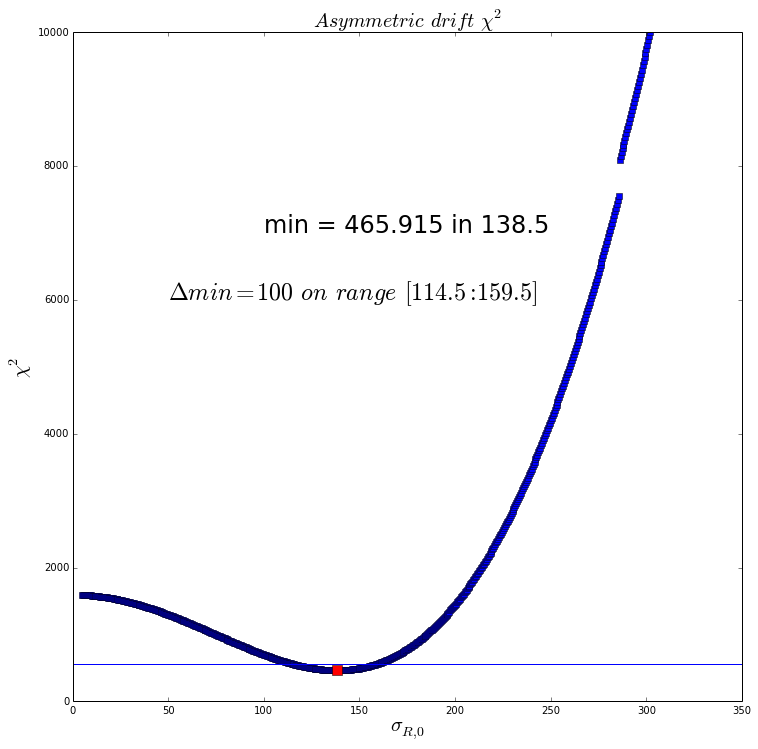

In [271]:
def plot_chi2_drift(sigmas, drifts):
    plt.plot(sigmas, drifts, 's')
    ind = drifts.index(min(drifts))
    value = drifts[ind]
    plt.plot(sigmas[ind], value, 's', color='red', ms=10.)
    plt.title('$Asymmetric\, drift\, \chi^2$', size=20.)
    plt.xlabel('$\sigma_{R,0}$', size=20.)
    plt.ylabel('$\chi^2$', size=20.)
    plt.ylim(0, 10000)
    plt.text(100, 7000, 'min = %.3f in %s' % (value, sigmas[ind]), size = 24.)
    plt.axhline(y=value+100)
    accep_val = filter(lambda l: l < value+100, drifts)
    ind_l = drifts.index(accep_val[0]); ind_r = drifts.index(accep_val[-1])
    plt.text(50, 6000, '$\Delta min=100\, on\, range\, [%s:%s]$' %(sigmas[ind_l], sigmas[ind_r]) , size = 24.)
    plt.show()
    

plot_chi2_drift(sigmas, drift_err)

Разрыв - из-за того, что NaN был. В целом картинка оочень хорошая - виден четкий минимум без широкого плато и все в том же примерно месте, что и раньше. Посмотрим глазами на предсказываемую в этой точке круговую скорость:

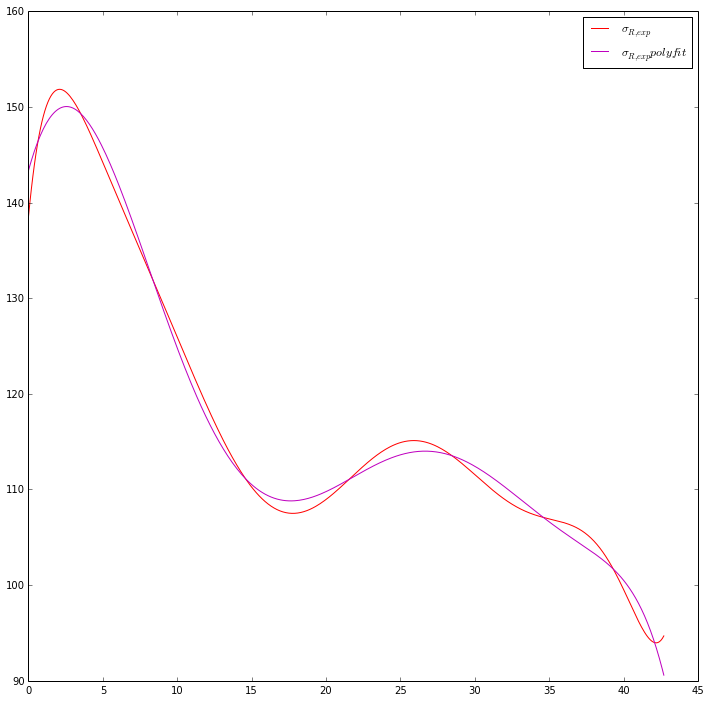

In [272]:
sig_R_0 = 138.5
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
plt.plot(points, [sigR_exp(R) for R in points], '-', color='red', label='$\sigma_{R, exp}$')
plt.plot(points, [poly_marj_R(R) for R in points], '-', color='m', label='$\sigma_{R, exp} polyfit$')
plt.legend()
plt.show()

Теперь нанесем туда же данные по газу:

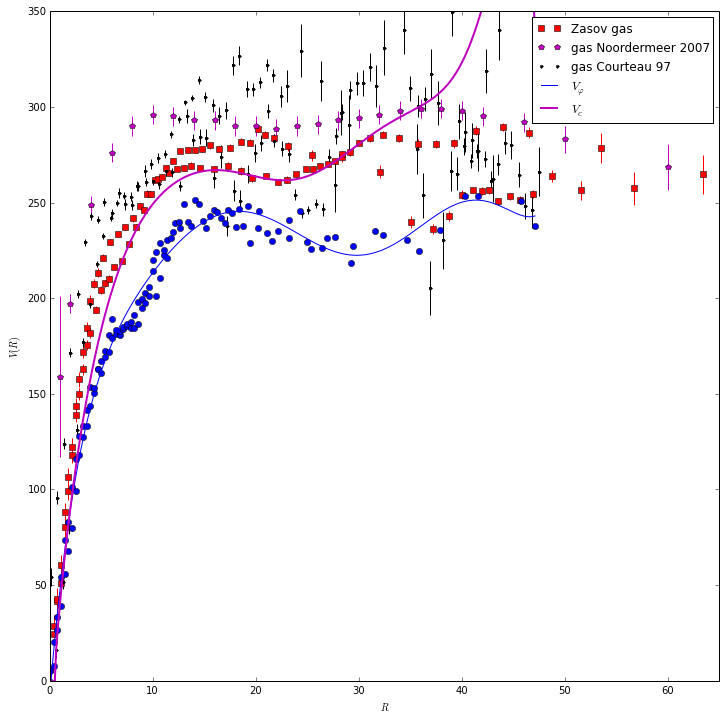

In [273]:
plt.plot(r_g_b, vel_g_b, 's', label = 'Zasov gas', color='red')
plt.errorbar(r_g_b, vel_g_b, yerr=e_vel_g_b, fmt='.', marker='.', mew=0, color='red')
plt.plot(r_wsrt, vel_wsrt, 'p', label="gas Noordermeer 2007", color='m')
plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='m')
plt.plot(r_c_b, vel_c_b, '.', label = 'gas Courteau 97', color='black')
plt.errorbar(r_c_b, vel_c_b, yerr=e_vel_c_b, fmt='.', marker='.', mew=0, color='black')

plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='blue', label=r'$V_{\varphi}$')
predict_drift = lambda l: asym_drift_value(l) + poly_star(l)**2 
predict_gas = lambda l: sqrt(predict_drift(l)) if predict_drift(l) > 0 else -100
plt.plot(test_points, [predict_gas(R) for R in test_points], 
         '-', color='m', label=r'$V_c$', lw=2.)
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V(R)$')
plt.ylim(0, 350)
plt.xlim(0, 65)
plt.legend()
plt.show()

In [274]:
#Ошибка еще раз: теперь до 40''
sum(power([predict_gas(p[0]) - p[1] for p in 
           filter(lambda l: l[0] < 40., zip(r_g_b, vel_g_b))], 2))/len(filter(lambda l: l < 40., r_g_b))

792.84697810487319

Очень интересный результат! Фактически предсказываемая кривая вращения газа полностью совпадает с данными Засова, которые мы априори считаем наиболее релевантными.

## 3. Отношение вертикальной дисперсии к радиальной 

Если мы с высокой достоверностью определили $\sigma_R$, то какое значение $\alpha$ ему соответствует? Посчитать нужный профиль мы можем простым вычитанием: $$\sigma_Z = \frac{1}{\cos i}\sqrt{\sigma_{los,min}^2 - \sigma_R^2\sin^2i}$$ После вычитания мы сможем проверить, какое получается отношение $\alpha$ вдоль профиля (оно в силу формул будет константой, но какой?).

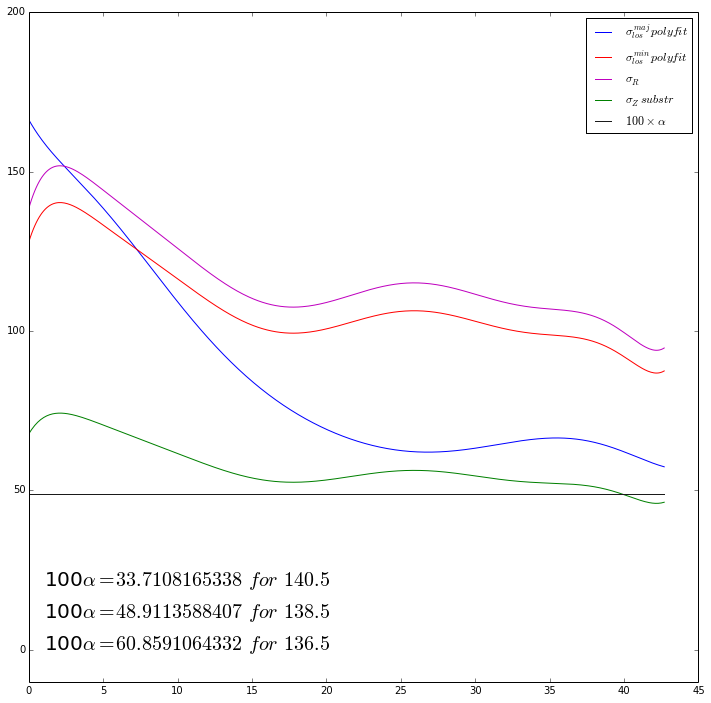

In [275]:
#Пусть это наиболее вероятное значение sigR_0
sig_R_0 = 138.5
#Его вероятная ошибка
dsig_R0 = 2.

def sigZ_from_substr(R):
    '''Вычисление sigZ вичитанием готового профиля sigR'''
    sq2 = poly_sig_min(R)**2 - sigR_exp(R)**2 * sin_i**2
    if sq2 > 0:
        return sqrt(sq2)/cos_i
    else:
        return 0.0


plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(points, [sigR_exp(R) for R in points], label = '$\sigma_R$', color='m')
plt.plot(points, [sigZ_from_substr(R) for R in points], label = '$\sigma_Z substr$', color='g')
plt.plot(points, [100*sigZ_from_substr(R)/sigR_exp(R) for R in points], 
         '-', label = r'$100\times\,\alpha$', color=(0.1,0.1,0.1))
plt.text(1, 10, r"100$\alpha=%s\, for\, %s$" % 
         (100*sigZ_from_substr(0.)/sigR_exp(0.), sig_R_0), fontsize=20, color='black')

#Верхняя граница
sig_R_0 = sig_R_0 - dsig_R0
plt.text(1, 0, r"100$\alpha=%s\, for\, %s$" % 
         (100*sigZ_from_substr(0.)/sigR_exp(0.), sig_R_0), fontsize=20, color='black')

#Нижняя граница
sig_R_0 = sig_R_0 + 2*dsig_R0
plt.text(1, 20, r"100$\alpha=%s\, for\, %s$" % 
         (100*sigZ_from_substr(0.)/sigR_exp(0.), sig_R_0), fontsize=20, color='black')

plt.legend()
plt.ylim(-10, 200)
plt.show()

## 4. Приложения

### 4.1 Хаббловские типы

Shapiro и Gerssen в статье 2003 года (http://arxiv.org/abs/astro-ph/0308489) "Observational Constraints on Disk Heating as a Function of Hubble Type" пытались проследить зависимость отношения $\sigma_Z/\sigma_R$ для галактик разных хаббловских типов. Неплохо было бы ради интереса на их график добавить и нашу полученную точку. У 338 тип Sab, т.е. располагается она чуть правее крайней левой отметки.

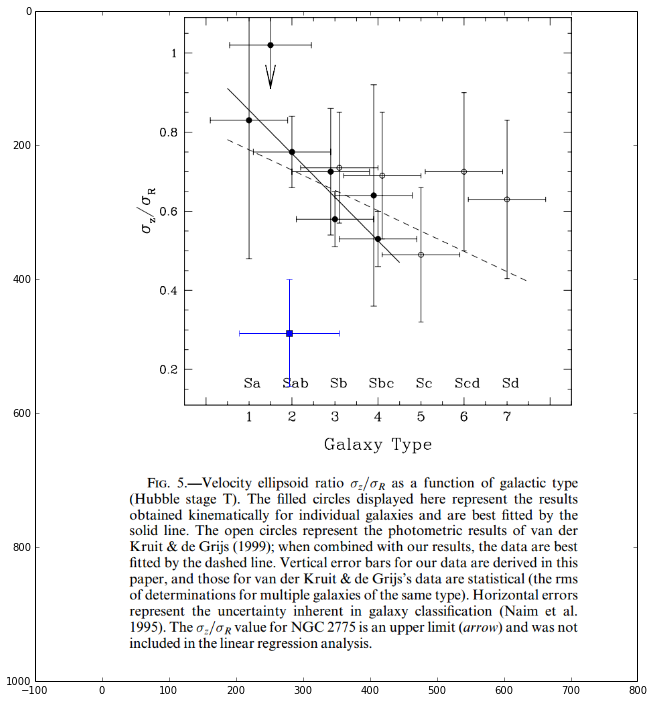

In [276]:
os.chdir("C:\\science\\2FInstability\\notebooks")

plt.imshow(np.asarray(pil.Image.open("shapiro_2003_hubble_type.png")))
# Значение, которое мы получили только что
plt.plot(280, 480, 's', color='blue')
plt.errorbar(280, 480, yerr=80, xerr=75, color='blue')
# plt.text(260, 540, "$Sab$", fontsize=20, color='red')
plt.ylim(1000, 0)
plt.show()

### 4.2 Кинетический масштаб

Еще одна важная идея, на которую тоже интересно посмотреть - кинематический масштаб. Gerssen и Shapiro в своих работах восстанавливают профиль дисперсий скоростей исходя из предположения об его экспоненциальной форме: $$\sigma_R = \sigma_{R,0}\exp(-R/h_{kin}),$$ $$\sigma_Z = \sigma_{Z,0}\exp(-R/h_{kin}),$$ где характерный экспоненциальный масштаб предполагается равным для обоих профилей (и это и есть кинематический масштаб). Из неких предположений следует, что этот масштаб равен удвоенному масштабу диска: $h_{kin}=2h_d$, но это проверять на будущее - когда будет известна фотометрия.  

Найдем кинетический масштаб и профили, которые получились бы у них для NGC 338. Сделать это довольно легко: $$\sigma_{los,min}^2 = \sigma_R^2\sin^2i + \sigma_Z^2\cos^2i,$$ а значит из предположения выше $$\sigma_{los,min}^2 = \exp(-2R/h_{kin})\times(\sigma_{R,0}^2\sin^2i + \sigma_{Z,0}^2\cos^2i),$$ а если взять логарифм: $$2\ln\sigma_{los,min} = -2R/h_{kin} + \ln(\rm{const}).$$ Приблизим точки прямой и константа при y будет равно обратному кинематическому масштабу. 

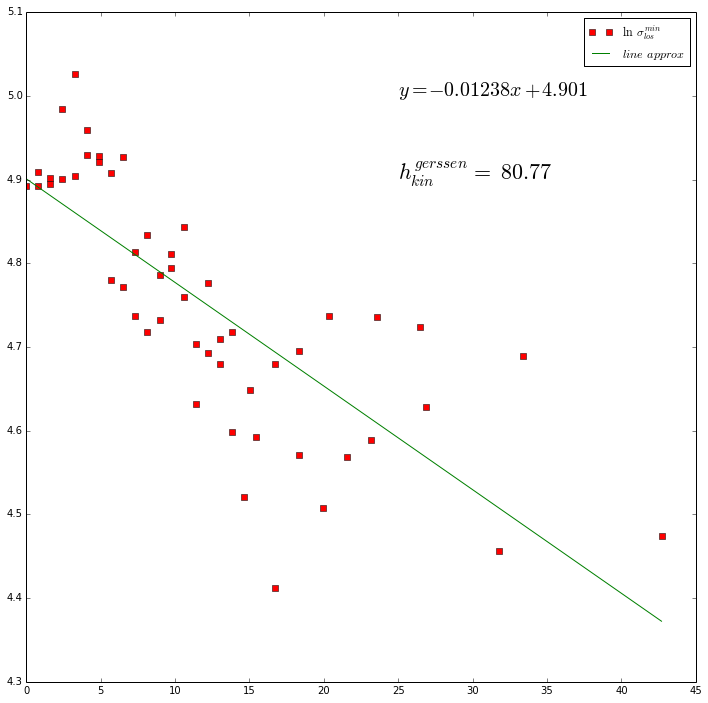

In [277]:
sig_min_p_ln = [math.log(p) for p in sig_min_p]

poly_ln = poly1d(polyfit(radii_min, sig_min_p_ln, deg=1))
h_kin_gerssen = float("{0:.2f}".format(-1./poly_ln[1]))

plt.plot(radii_min, sig_min_p_ln, 's', label='$\ln\,{\sigma_{los}^{min}}$', color='red')
plt.plot(points, [poly_ln(R) for R in points], label = '$line\, approx$', color='g')
plt.text(25, 5.0, r"$y=%s$" % poly_ln.__str__()[2:], fontsize=20, color='black')
plt.text(25, 4.9, r"$h_{kin}^{gerssen}=\,%s$" % h_kin_gerssen, fontsize=22, color='black')

plt.legend()
plt.show()

Запишем МНК, решив которую мы сможем также найти $\alpha$ при данном $h_{kin}$ (идея как и раньше, раз мы взяли герсеновскую параметризацию профилей). В дипломе такое не было сделано - просто брали $\alpha=0.5$.
Неизвестные: $\sigma_{R,0}^2\sin^2 i \equiv A,\ \sigma_{R,0}^2\cos^2 i\times \alpha^2 \equiv B$.
$$\left\{
  \begin{array}{lr}
    \sigma_{los,maj}^2(R_j)=\exp(-2R_j/h_{kin})\times[Af(R_j)+B]\\
    \sigma_{los, min}^2(R_j)=\exp(-2R_j/h_{kin})\times[A+B]
  \end{array}
\right.
$$

In [278]:
def lsq_alpha_gerssen(h_kin):
    '''
    МНК для нахождения alpha методом примерно как у Gerssen - экспоненциальные профили. 
    Считаем честно для наблюдательных точек.
    '''
    #Начальное приближение (А,В)
    x0 = [1000, 1000]
    
    #Уравнения:
    #Левая часть:
    eq_left = np.concatenate( ([p[1]**2/exp(-2*p[0]/h_kin) for p in zip(radii_maj, sig_maj_p)], 
                               [p[1]**2/exp(-2*p[0]/h_kin) for p in zip(radii_min, sig_min_p)]) )
    #Правая часть:
    eq_right = np.transpose(
                np.array([
                    np.concatenate(([sigPhi_to_sigR(R)**2 for R in radii_maj], 
                                    [1.]*radii_min.__len__())),
                    np.concatenate(([1.]*radii_maj.__len__(), 
                                    [1.]*radii_min.__len__()))]))
    
    # МНК для получившихся уравнений:
    solution = scipy.optimize.leastsq(residuals, x0, args=(eq_right, eq_left))[0]
    A, B = solution[0], solution[1]
    
    chi2 = sum(power(residuals(solution, eq_right, eq_left), 2))
            
    print 'Solution: A = %s, B = %s' % (A, B)
    print 'Chi^2:', chi2
    
    sig_R_0 = round( sqrt(A) / sin(incl*pi/180), 3)
    alpha = round( sqrt(B)/ (cos(incl*pi/180) * sig_R_0), 3)
    
    print "sig_R_0 = %s, alpha = %s" % (sig_R_0, alpha)
    return sig_R_0, alpha
    
lsq_alpha_gerssen(h_kin_gerssen)

Solution: A = 19902.9195415, B = 1404.40721253
Chi^2: 3269898350.39
sig_R_0 = 156.963, alpha = 0.545


(156.963, 0.545)

Да, такой результат действительно лучше вписывается в тренд для хаббловских типов. Попробуем еще то же, но с $h_{kin}=2h_d$:


In [279]:
lsq_alpha_gerssen(2 * h_d)

Solution: A = 6785.12106497, B = 29205.3769487
Chi^2: 110676899406.0
sig_R_0 = 91.647, alpha = 4.254


(91.647, 4.254)

Не похоже на правду. Возьмем в последний раз $h_{kin}\, примерно\, 50$:

In [280]:
lsq_alpha_gerssen(50.)

Solution: A = 18954.141235, B = 5259.4330444
Chi^2: 4201083413.83
sig_R_0 = 153.176, alpha = 1.08


(153.176, 1.08)

Заведем функции для восстановления профиля при герсеновских экспоненциальных предположениях. 

In [281]:
def sigR_ger_exp(R):
    return sig_R_0*exp(-R/h_kin_gerssen)

def sigZ_ger_exp(R):
    return sigR_ger_exp(R)*alpha

def sigPhi_ger_exp(R):
    return sigPhi_to_sigR(R) * sigR_ger_exp(R)

def sig_maj_ger_exp(R):
    return sqrt(sigPhi_ger_exp(R)**2 * sin_i**2 + sigZ_ger_exp(R)**2 * cos_i**2)

def sig_min_ger_exp(R):
    return sqrt(sigR_ger_exp(R)**2 * sin_i**2 + sigZ_ger_exp(R)**2 * cos_i**2)

Solution: A = 19902.9195415, B = 1404.40721253
Chi^2: 3269898350.39
sig_R_0 = 156.963, alpha = 0.545


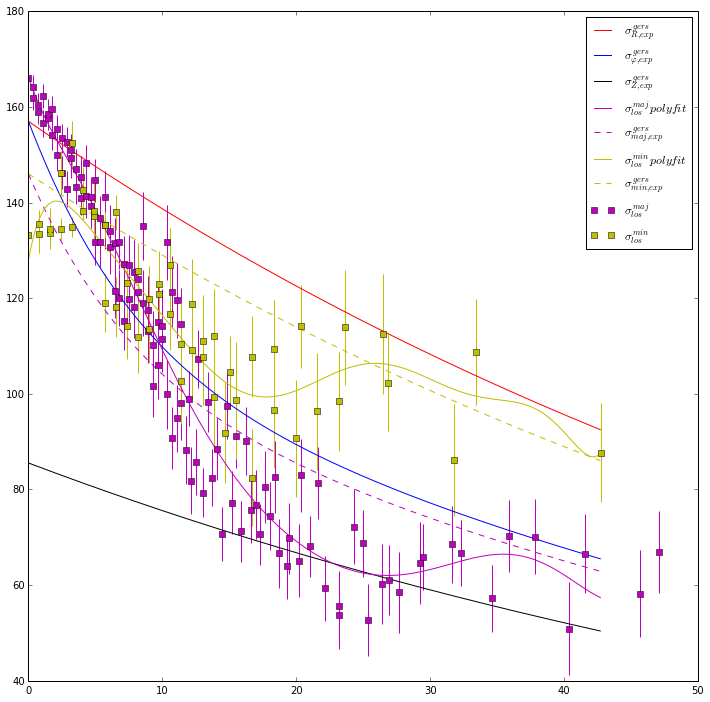

In [282]:
sig_R_0, alpha = lsq_alpha_gerssen(h_kin_gerssen)

plt.plot(points, [sigR_ger_exp(R) for R in points], '-', color='red', label='$\sigma_{R, exp}^{gers}$')
plt.plot(points, [sigPhi_ger_exp(R) for R in points], '-', color='blue', label=r'$\sigma_{\varphi, exp}^{gers}$')
plt.plot(points, [sigZ_ger_exp(R) for R in points], '-', color='black', label='$\sigma_{Z, exp}^{gers}$')
plt.plot(points, poly_sig_maj(points), '-', label = '$\sigma_{los}^{maj} polyfit$', color='m')
plt.plot(points, [sig_maj_ger_exp(R) for R in points], '--', color='m', label='$\sigma_{maj, exp}^{gers}$')
plt.plot(points, poly_sig_min(points), '-', label = '$\sigma_{los}^{min} polyfit$', color='y')
plt.plot(points, [sig_min_ger_exp(R) for R in points], '--', color='y', label='$\sigma_{min, exp}^{gers}$')

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='m')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='m')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='y')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='y')

plt.legend()
plt.show()

Определим теперь, какой кинетический масштаб получается в нашем способе, непосредственно приблизив профили $\ln \sigma_R(R)$ и $\ln \sigma_Z(R)$ прямыми как и раньше:

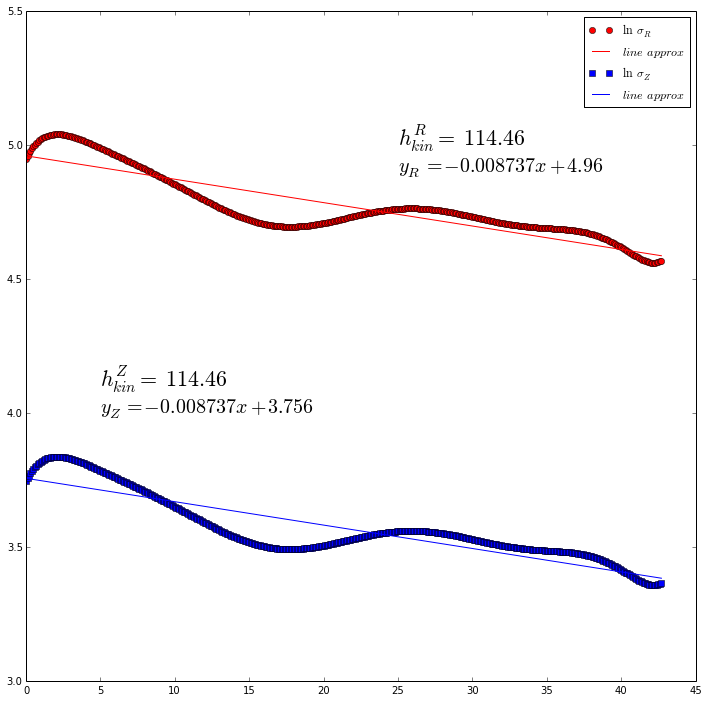

In [283]:
sig_R_0 = 141.
alpha = 0.3

sig_R_p_ln = [math.log(p) for p in [sigR_exp(R) for R in points]]
sig_Z_p_ln = [math.log(p) for p in [sigZ_exp(R) for R in points]]

poly_ln_R = poly1d(polyfit(points, sig_R_p_ln, deg=1))
h_kin_R = float("{0:.2f}".format(-1./poly_ln_R[1]))

poly_ln_Z = poly1d(polyfit(points, sig_Z_p_ln, deg=1))
h_kin_Z = float("{0:.2f}".format(-1./poly_ln_Z[1]))

plt.plot(points, sig_R_p_ln, 'o', label='$\ln\,{\sigma_R}$', color='red')
plt.plot(points, [poly_ln_R(R) for R in points], label = '$line\, approx$', color='r')
plt.text(25, 4.9, r"$y_R=%s$" % poly_ln_R.__str__()[2:], fontsize=20, color='black')
plt.text(25, 5.0, r"$h_{kin}^{R}=\,%s$" % h_kin_R, fontsize=22, color='black')

plt.plot(points, sig_Z_p_ln, 's', label='$\ln\,{\sigma_Z}$', color='b')
plt.plot(points, [poly_ln_Z(R) for R in points], label = '$line\, approx$', color='b')
plt.text(5., 4., r"$y_Z=%s$" % poly_ln_Z.__str__()[2:], fontsize=20, color='black')
plt.text(5., 4.1, r"$h_{kin}^{Z}=\,%s$" % h_kin_Z, fontsize=22, color='black')

plt.legend()
plt.show()

### 4.3 Уточнение линейной теории

Если мы достаточно точно оценим сверху $\sigma_{R}$: $\sigma_{R}^{up} \gtrsim \sigma_{R}$, то мы сможем написать нижнюю оценку на $\frac{\sigma_Z}{\sigma_R}$ и сравнить ее с 0.3. После несложных подсчетов получается следующая оценка:
$$\sqrt{(\sigma_{los,min}^2-\sigma_{R}^{2,up}\sin^2i)/(\sigma_{R}^{2,up}\cos^2i)} < \alpha$$